In [1]:
from MyLoad import MyLoadDATA
data = MyLoadDATA()

.\content\DATA\00048035\00048035.json
.\content\DATA\01142281\01142281.json
.\content\DATA\016047953\106047953.json
.\content\DATA\01990231\01990231.json
.\content\DATA\03158534\03158534.json
.\content\DATA\03877078\03877078.json
.\content\DATA\04886479\04886479.json
.\content\DATA\05609172\05609172.json
.\content\DATA\06280116\06280116.json
.\content\DATA\08485336\08485336.json
.\content\DATA\10874765\10874765.json
.\content\DATA\10929576\10929576.json
.\content\DATA\11830358\11830358.json
.\content\DATA\13549073\13549073.json
.\content\DATA\15144615\151446151.json
.\content\DATA\16060746\16060746.json


In [2]:
print('No. of image:', len(data))
print('No. of labels:', sum([len(d['x_label']) for d in data]))
print('\tnormal:', len([t for d in data for t in d['type'] if t == 'normal']))
print('\tcompre:', len([t for d in data for t in d['type'] if t == 'compre']))
print('\tburst:', len([t for d in data for t in d['type'] if t == 'burst']))
print('\tunsure:', len([t for d in data for t in d['type'] if t == 'unsure']))

No. of image: 143
No. of labels: 1486
	normal: 1191
	compre: 172
	burst: 4
	unsure: 119


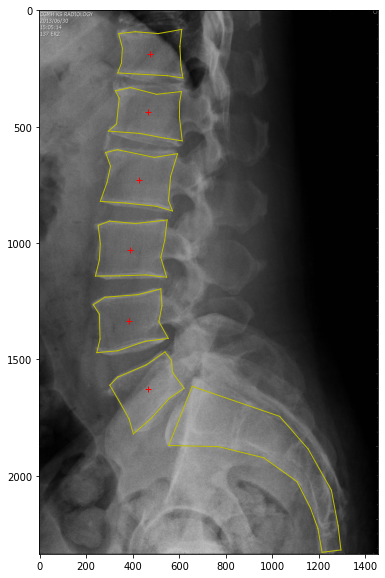

In [3]:
from MyLoad import plotLabel

plotLabel(data[-1])

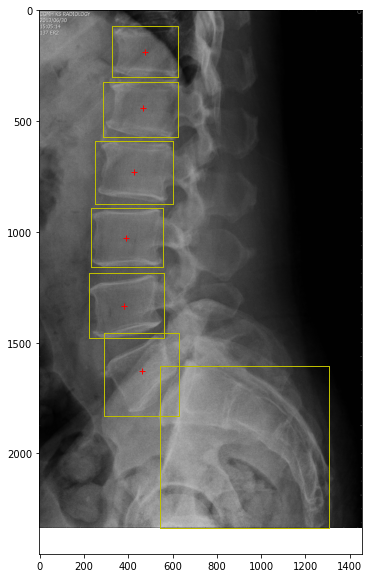

In [4]:
from MyLoad import plotBox

# default width height excess 35
plotBox(data[-1], 10, 10)

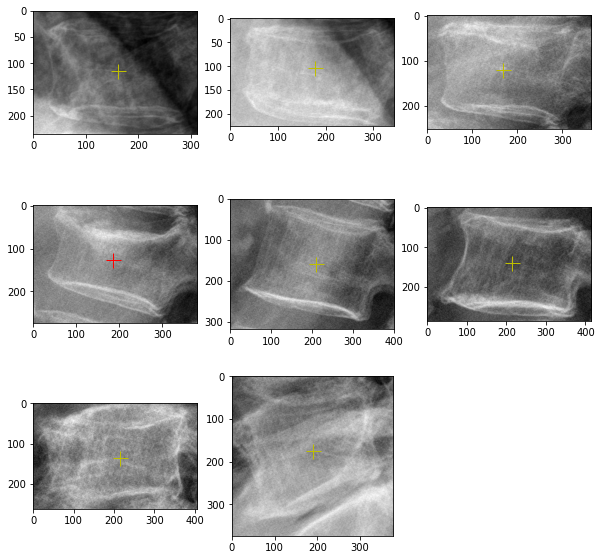

In [5]:
from MyLoad import plotBoxZoom

plotBoxZoom(data[46], width=20, height=20)

In [6]:
print(data[0].keys())
print(data[0]['y_label'][0])

dict_keys(['filename', 'filepath', 'x_label', 'y_label', 'position', 'type'])
[216, 236, 275, 322, 272, 254, 239, 194, 143, 126, 146, 186]


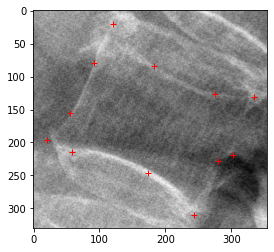

In [7]:
from PIL import Image
from matplotlib import pyplot as plt

ix = 3
seg_ix = 4

box = (
    min(data[ix]['x_label'][seg_ix])-20, 
    min(data[ix]['y_label'][seg_ix])-20, 
    max(data[ix]['x_label'][seg_ix])+20, 
    max(data[ix]['y_label'][seg_ix])+20,
    )
seg_x = [x-box[0] for x in data[ix]['x_label'][seg_ix]]
seg_y = [y-box[1] for y in data[ix]['y_label'][seg_ix]]
img = Image.open(data[ix]['filepath']).crop(box)
plt.imshow(img, cmap='gray')

for x, y in zip(seg_x, seg_y):
    plt.plot(x,y, 'r+')

In [8]:
import math

class bound_funct:

    def __init__(self, dots):
        
        self.dots = dots
        self.b = []
        self.a = []
        for i in range(len(dots)-1):
            if (dots[i][0]-dots[i+1][0]) == 0:
                dots[i] = (dots[i][0]+1, dots[i][1]) # temp
            a = (dots[i][1]-dots[i+1][1])/(dots[i][0]-dots[i+1][0])
            b = dots[i][1] - a * dots[i][0]
            self.a.append(a)
            self.b.append(b)

    def get_y(self, x):

        if x < self.dots[0][0]:
            raise ValueError("x out of range (smaller)")
        elif x < self.dots[1][0]:
            return self.a[0] * x + self.b[0]
        elif x < self.dots[2][0]:
            return self.a[1] * x + self.b[1]
        elif x <= self.dots[3][0]:
            return self.a[2] * x + self.b[2]
        else:
            raise ValueError("x out of range (larger)")


84 84.0


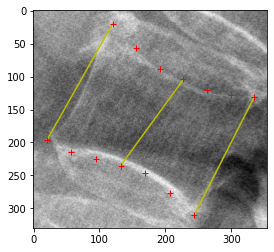

In [9]:
dots = [(x, y) for x,y in zip(seg_x, seg_y)]
uppers = [dots[i] for i in [0, 11, 10, 9]]
lowers = [dots[i] for i in [3, 4, 5, 6]]

a = (uppers[0][1]-uppers[1][1])/(uppers[0][0]-uppers[1][0])
b = uppers[0][1] - a * uppers[0][0]
print(uppers[1][1], a*uppers[1][0] + b)

plt.imshow(img, cmap='gray')
# for idx in range(len(uppers)-1):
#     plt.plot([uppers[idx][0], uppers[idx+1][0]], [uppers[idx][1], uppers[idx+1][1]], 'r-')
#     plt.plot([lowers[idx][0], lowers[idx+1][0]], [lowers[idx][1], lowers[idx+1][1]], 'r-')

f_upper = bound_funct(uppers)
f_lower = bound_funct(lowers)
uppper_x = [uppers[0][0]+k*(uppers[3][0]-uppers[0][0])/6 for k in range(7)]
lower_x = [lowers[0][0]+k*(lowers[3][0]-lowers[0][0])/6 for k in range(7)]

for idx, (ux, lx) in enumerate(zip(uppper_x, lower_x)):

    if idx %3 == 0:
        plt.plot([ux, lx], [f_upper.get_y(ux), f_lower.get_y(lx)], 'y-')

    plt.plot([ux, lx], [f_upper.get_y(ux), f_lower.get_y(lx)], 'r+')

# for i in uppper_x:
#     plt.plot(i, f_upper.get_y(i), 'y+')

# for i in lower_x:
#     plt.plot(i, f_lower.get_y(i), 'y+')
 

In [10]:
import pandas as pd
import numpy as np
import math

features = []
for fid, d in enumerate(data):

    full_img = Image.open(data[ix]['filepath'])

    for ix in range(len(d['x_label'])):

        if d['type'] == 'S':
            break
        elif len(d['x_label'][ix]) != 12:
            # print(d['filename'])
            continue

        seg_x = [x for x in d['x_label'][ix]]
        seg_y = [y for y in d['y_label'][ix]]

        dots = [(x, y) for x,y in zip(seg_x, seg_y)]
        uppers = [dots[i] for i in [0, 11, 10, 9]]
        lowers = [dots[i] for i in [3, 4, 5, 6]]

        f_upper = bound_funct(uppers)
        f_lower = bound_funct(lowers)
        upper_line = [uppers[0][0]+k*(uppers[3][0]-uppers[0][0])/6 for k in range(7)]
        lower_line = [lowers[0][0]+k*(lowers[3][0]-lowers[0][0])/6 for k in range(7)]
        feature = []

        feature.append(fid)
        feature.append(d['filename'])
        feature.append(d['position'][ix])
        feature.append(d['type'][ix])

        # measured legth
        for iu, il in zip(upper_line, lower_line):
            feature.append(np.sqrt((iu-il) **2 + (f_upper.get_y(iu)-f_lower.get_y(il))**2))

        if upper_line[3] == lower_line[3]:
            # feature.append(math.inf)
            feature.append(100000)
        else:
            feature.append((f_upper.get_y(upper_line[3])-f_lower.get_y(lower_line[3]))/(upper_line[3]-lower_line[3]))

        features.append(feature)

df = pd.DataFrame(
    features, 
    columns=['fid', 'filename', 'position', 'vtype'] + ['Len'+str(i) for i in range(7)] + ['slope']
    )

df['ratio03'] = df['Len3']/df['Len0']
df['ratio06'] = df['Len6']/df['Len0']
df['ratio36'] = df['Len3']/df['Len6']

def posEncode(pos):
    if 'L' in pos:
        return 0
    elif 'T' in pos:
        return 1
    else: # S or C
        return 2
def typeEncode(vtype):
    if vtype == 'compre':
        return 0    
    elif vtype == 'normal':
        return 1
    elif vtype =='burst':
        return 2
    else:
        return 3

df['pos_encode'] = np.array([posEncode(a)  for a in df['position']])
df['vtype_encode'] = np.array([typeEncode(a) for a in df['vtype']])

df.head()

,fid,filename,position,vtype,Len0,Len1,Len2,Len3,Len4,Len5,Len6,slope,ratio03,ratio06,ratio36,pos_encode,vtype_encode
0,0,00048035_FILE0.bmp,T2,normal,127.581347,126.374984,125.208559,129.121594,137.578577,138.345741,137.306227,1.415591,1.012073,1.076225,0.940391,1,1
1,0,00048035_FILE0.bmp,T3,normal,153.574086,138.760163,125.131392,124.427475,128.315784,137.198454,156.425701,1.424237,0.810211,1.018568,0.795441,1,1
2,0,00048035_FILE0.bmp,T4,normal,138.924440,133.905945,132.456566,130.589097,132.559812,136.563308,154.508899,1.316243,0.940001,1.112179,0.845188,1,1
3,0,00048035_FILE0.bmp,T5,normal,137.083916,131.280176,125.563222,128.158885,133.508695,143.404160,156.169779,2.058511,0.934894,1.139228,0.820638,1,1
4,0,00048035_FILE0.bmp,T6,normal,139.215660,139.296151,137.401479,134.811789,134.444716,141.484596,165.081798,2.896120,0.968367,1.185799,0.816636,1,1


In [11]:
slope_angle = []

for i in range(len(df)-1):
    
    if df.iloc[i+1]['position'] == 'T1' or df.iloc[i+1]['position'] == 'S':
        slope_angle.append(-100)

    else:
        vec1 = (1, df.iloc[i]['slope'])
        vec2 = (-1, -df.iloc[i+1]['slope'])

        abs1 = math.sqrt(1 + vec1[1] ** 2)
        abs2 = math.sqrt(1 + vec2[1] ** 2)

        vecdot = vec1[0] * vec2[0] + vec1[1] * vec2[1]
        # print(vecdot/(abs1*abs2))
        if vecdot == math.inf:
            slope_angle.append(-100)
            continue
        slope_angle.append(math.degrees(math.acos(vecdot/(abs1*abs2))))

slope_angle.append(-100)

df['slope_angle'] = np.array(slope_angle)

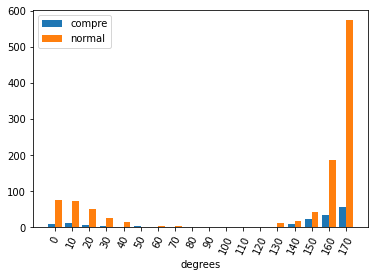

In [12]:
# fig, ax = plt.subplots(1,2, figsize=(10,5))

test_compre = np.array(df[df['vtype_encode']==0]['slope_angle'])
test_normal = np.array(df[df['vtype_encode']==1]['slope_angle'])

# test_normal = np.array([180-d if d > 90 else d for d in test_normal])
# test_compre = np.array([180-d if d > 90 else d for d in test_compre])

X = [i for i in range(18)]
y = [len(test_compre[(test_compre<=10*(i+1)) & (test_compre>10*i)]) for i in range(18)]

plt.bar([2*x for x in X], y)

y = [len(test_normal[(test_normal<=10*(i+1)) & (test_normal>10*i)]) for i in range(18)]

plt.bar([2*x+0.8 for x in X],y)

plt.xticks([2*x+0.4 for x in X], [str(10*x) for x in X], rotation=65)
plt.xlabel('degrees')
plt.legend(['compre', 'normal'])

E6.bmp
312    03158534_FILE6.bmp
313    03158534_FILE6.bmp
Name: filename, dtype: object
305    03158534_FILE6.bmp
306    03158534_FILE6.bmp
307    03158534_FILE6.bmp
308    03158534_FILE6.bmp
309    03158534_FILE6.bmp
310    03158534_FILE6.bmp
311    03158534_FILE6.bmp
312    03158534_FILE6.bmp
313    03158534_FILE6.bmp
Name: filename, dtype: object
322    03158534_FILE8.bmp
323    03158534_FILE8.bmp
324    03158534_FILE8.bmp
325    03158534_FILE8.bmp
326    03158534_FILE8.bmp
327    03158534_FILE8.bmp
328    03158534_FILE8.bmp
329    03158534_FILE8.bmp
330    03158534_FILE8.bmp
331    03158534_FILE8.bmp
332    03158534_FILE8.bmp
333    03158534_FILE8.bmp
334    03158534_FILE8.bmp
335    03158534_FILE8.bmp
336    03158534_FILE8.bmp
Name: filename, dtype: object
337    03158534_FILE9.bmp
338    03158534_FILE9.bmp
339    03158534_FILE9.bmp
340    03158534_FILE9.bmp
341    03158534_FILE9.bmp
342    03158534_FILE9.bmp
343    03158534_FILE9.bmp
Name: filename, dtype: object
373    03158534

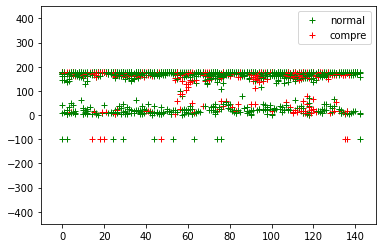

In [13]:
a = df.iloc[-1]['fid']

for i in range(a+1):

    plt.plot(0, -100000, 'g+')
    plt.plot(0, -100000, 'r+')
    plt.xlim([-10, 150])
    plt.ylim([-450, 450])
    plt.legend(['normal', 'compre'])

    for y, l in zip(list(df[df['fid'] == i]['slope_angle']), list(df[df['fid'] == i]['vtype'])):

        if y > 80000:
            continue
        if y <=10:
            print(df[df['fid'] == i]['filename'])

        if l == 'normal':
            color = 'g+'
        else:
            color = 'r+'
        plt.plot(i, y, color)

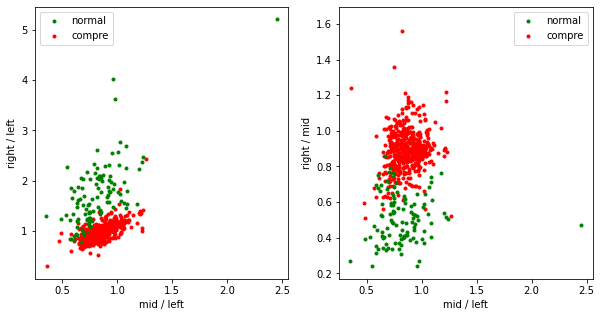

In [14]:
color_selector = {
    'normal': 'r.',
    'compre': 'g.',
    'burst': '',
    'unsure': '',
}

fig, ax = plt.subplots(1,2, figsize=(10,5))

# ax[0].set_xlim(0,3)
# ax[0].set_ylim(0,2.5)
# ax[1].set_xlim(0,1.5)
# ax[1].set_ylim(0,2.5)

ax[0].set_xlabel('mid / left')
ax[0].set_ylabel('right / left')

ax[1].set_xlabel('mid / left')
ax[1].set_ylabel('right / mid')

for i, row in df.iterrows():
    if 'L' in row['position']:
        ax[0].plot(row['ratio03'], row['ratio06'], color_selector[row['vtype']])
        # if row['vtype'] == 'compre':
        ax[1].plot(row['ratio03'], row['ratio36'], color_selector[row['vtype']])

ax[0].legend(['normal', 'compre'])
ax[1].legend(['normal', 'compre'])

In [15]:
df[df['vtype_encode']==0]['Len0']

11       86.406018
20       81.154174
31       88.323270
39       77.665951
48       56.008928
           ...    
1218    135.793962
1220    126.846364
1226    102.122475
1230    133.988806
1232    127.612695
Name: Len0, Length: 165, dtype: float64

Text(0.5, 1.0, 'Lumbar')

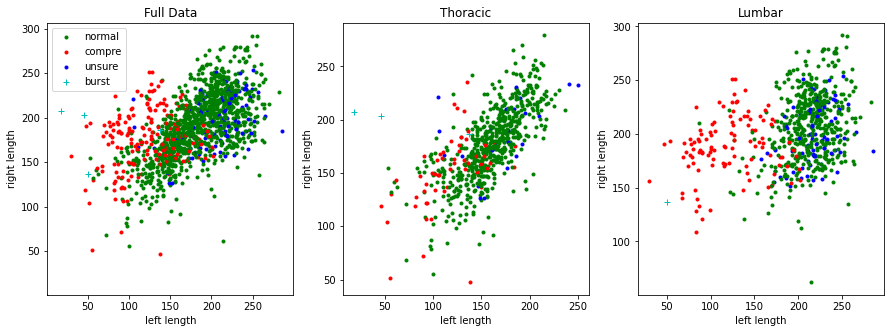

In [16]:
from matplotlib import pyplot as plt

marker_selector = {
    'normal': 'g.',
    'compre': 'r.',
    'unsure': 'b.',
    'burst': 'c+',
    'Spine': 'm.',
}


fig, ax = plt.subplots(1,3, figsize=(15,5))

for k in marker_selector.keys():
    ax[0].plot(0,0,marker_selector[k])

for i, row in df.iterrows():

    marker = marker_selector[row['vtype']]

    if row['position'] != 'S':
        ax[0].plot(row['Len0'], row['Len6'], marker)

ax[0].set_xlim(1)
ax[0].set_ylim(1)
ax[0].set_xlabel('left length')
ax[0].set_ylabel('right length')
ax[0].set_title('Full Data')
ax[0].legend(['normal', 'compre', 'unsure', 'burst'])


for i, row in df.iterrows():

    marker = marker_selector[row['vtype']]

    if row['position'] != 'S' and 'T' in row['position']:
        ax[1].plot(row['Len0'], row['Len6'], marker)

ax[1].set_xlabel('left length')
ax[1].set_ylabel('right length')
ax[1].set_title('Thoracic')

for i, row in df.iterrows():

    marker = marker_selector[row['vtype']]

    if row['position'] != 'S' and 'L' in row['position']:
        ax[2].plot(row['Len0'], row['Len6'], marker)

ax[2].set_xlabel('left length')
ax[2].set_ylabel('right length')
ax[2].set_title('Lumbar')


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df = df[(df['vtype']=='normal') | (df['vtype'] == 'compre')]
df['pos_encode'] = np.array([1 if 'T' in a else 0 for a in df['position']])
df['vtype_encode'] = np.array([1 if a == 'normal' else 0 for a in df['vtype']])

df_normal = df[df['vtype'] == 'normal']
df_compre = df[df['vtype'] == 'compre']

df_normal_train, df_normal_test = train_test_split(df_normal, shuffle=True, test_size=0.2)
df_compre_train, df_compre_test = train_test_split(df_compre, shuffle=False, test_size=0.2)

# print(len(df_normal_train)/len(df_compre_train))
df_normal_trains = []
for i in range(int(len(df_normal_train)/len(df_compre_train))):
   df_normal_trains.append(df_normal_train[i*len(df_compre_train):(i+1)*len(df_compre_train)])
df_normal_trains.append(df_normal_train[(i+1)*len(df_compre_train):])

df_trains = [pd.concat([train_fraction, df_compre_train]) for train_fraction in df_normal_trains]
df_test  = pd.concat([df_normal_test , df_compre_test ])

# dropped = ['vtype_encode', 'vtype', 'position', 'Len1', 'Len2', 'Len4', 'Len5', 'slope_angle', 'slope']
selected = ['Len0', 'Len3', 'Len6', 'ratio03', 'ratio06', 'ratio36', 'pos_encode']

# X_train = np.array(df_train.drop(dropped, axis=1))
X_trains = [np.array(X_train[selected]) for X_train in df_trains]
X_test  = np.array(df_test[selected])
y_trains = [np.array(X_train['vtype_encode']) for X_train in df_trains]
y_test  = np.array(df_test['vtype_encode'])

for df_train in df_trains:
    print('# of train data', len(df_train))
    print('{:.0f}%'.format( 100*len(df_train[df_train['vtype'] == 'compre'])/len(df_train)) + ' compre')

print('# of test data', len(df_test))
print('{:.0f}%'.format(100*len(df_test[df_test['vtype'] == 'compre'])/len(df_test)) + ' compre')
print('feature selected: {}'.format([k for k in df_test.keys() if not k in dropped]))

# of train data 264
50% compre
# of train data 264
50% compre
# of train data 264
50% compre
# of train data 264
50% compre
# of train data 264
50% compre
# of train data 264
50% compre
# of train data 216
61% compre
# of test data 252
13% compre
feature selected: ['fid', 'filename', 'Len0', 'Len3', 'Len6', 'ratio03', 'ratio06', 'ratio36', 'pos_encode']


In [21]:
# apply under sampling method (https://towardsdatascience.com/what-to-do-when-your-classification-dataset-is-imbalanced-6af031b12a36)


import copy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

knn = KNeighborsClassifier()
dec = DecisionTreeClassifier()
rfc = RandomForestClassifier()

subsets = []

print('knn\tdec\trfc')

# for X_train, y_train in zip(X_trains, y_trains):

for valid_idx in range(len(X_trains)):

    if valid_idx != len(X_trains)-1 and valid_idx != 0:
        X_train = np.vstack( (np.vstack(X_trains[:valid_idx]), np.vstack(X_trains[valid_idx+1:])) )
        y_train = np.concatenate( (np.concatenate(y_trains[:valid_idx]), np.concatenate(y_trains[valid_idx+1:])) )
    elif valid_idx == len(X_trains)-1:
        X_train = np.vstack(X_trains[:valid_idx])
        y_train = np.concatenate(y_trains[:valid_idx])
    else:
        X_train = np.vstack(X_trains[1:])
        y_train = np.concatenate(y_trains[1:])

    temp_dict = dict()

    knn.fit(X_train, y_train)
    dec.fit(X_train, y_train)
    rfc.fit(X_train, y_train)

    # print('totally {} data'.format(len(X_train)))
    # print('with {:.0f}% normal'.format( 100*sum(int(i==1) for i in y_train)/len(y_train)))

    pred = knn.predict(X_test)
    # temp_dict['knn'] = sum(int(p==t) for p, t in zip(pred, y_test))/len(pred)
    acc_knn = sum(int(p==t) for p, t in zip(pred, y_test))/len(pred)
    temp_dict['knn'] = knn

    pred = dec.predict(X_test)
    # temp_dict['dec'] = sum(int(p==t) for p, t in zip(pred, y_test))/len(pred)
    acc_dec = sum(int(p==t) for p, t in zip(pred, y_test))/len(pred)
    temp_dict['dec'] = dec

    pred = rfc.predict(X_test)
    # temp_dict['rfc'] = sum(int(p==t) for p, t in zip(pred, y_test))/len(pred)
    acc_rfc = sum(int(p==t) for p, t in zip(pred, y_test))/len(pred)
    temp_dict['rfc'] = rfc

    subsets.append(copy.deepcopy(temp_dict))

    print('{:.3}\t{:.3}\t{:.3}\t| # of train data {}'.format(acc_knn, acc_dec, acc_rfc, len(X_train)))

pred_knn = []
pred_dec = []
pred_rfc = []
for subset in subsets:
    pred_knn.append(subset['knn'].predict(X_test))
    pred_dec.append(subset['dec'].predict(X_test))
    pred_rfc.append(subset['rfc'].predict(X_test))

pred_knn = np.where( (np.sum(np.array(pred_knn).T, axis=1))>3, 1, 0)
pred_dec = np.where( (np.sum(np.array(pred_dec).T, axis=1))>3, 1, 0)
pred_rfc = np.where( (np.sum(np.array(pred_rfc).T, axis=1))>3, 1, 0)

acc_knn = np.sum(np.where(pred_knn==y_test, 1, 0))/len(pred_knn)
acc_dec = np.sum(np.where(pred_dec==y_test, 1, 0))/len(pred_dec)
acc_rfc = np.sum(np.where(pred_rfc==y_test, 1, 0))/len(pred_rfc)

print('--------------7 fold validation----------------')
print('{:.3f}\t{:.3f}\t{:.3f}\t| {} fold on {} data'.format(acc_knn, acc_dec, acc_rfc, len(X_trains), sum(len(n) for n in X_trains)))

full_Xtrain = []
full_ytrain = []
for X_train, y_train in zip(X_trains, y_trains):
    full_Xtrain.extend(X_train)
    full_ytrain.extend(y_train)

knn.fit(full_Xtrain, full_ytrain)
dec.fit(full_Xtrain, full_ytrain)
rfc.fit(full_Xtrain, full_ytrain)

pred = knn.predict(X_test)
acc_knn = sum(int(p==t) for p, t in zip(pred, y_test))/len(pred)

pred = dec.predict(X_test)
acc_dec = sum(int(p==t) for p, t in zip(pred, y_test))/len(pred)

pred = rfc.predict(X_test)
acc_rfc = sum(int(p==t) for p, t in zip(pred, y_test))/len(pred)

print('-----------------full input--------------------')
print('{:.3}\t{:.3}\t{:.3}\t| train on {} data'.format(acc_knn, acc_dec, acc_rfc, len(full_Xtrain)))

knn	dec	rfc
0.905	0.937	0.944	| # of train data 1536
0.897	0.917	0.94	| # of train data 1536
0.893	0.929	0.944	| # of train data 1536
0.905	0.944	0.94	| # of train data 1536
0.901	0.948	0.937	| # of train data 1536
0.901	0.937	0.944	| # of train data 1536
0.897	0.933	0.94	| # of train data 1584
--------------7 fold validation----------------
0.901	0.944	0.940	| 7 fold on 1800 data
-----------------full input--------------------
0.901	0.948	0.94	| train on 1800 data


In [22]:
import pickle

with open('./MLmodel.pickle', 'wb') as f:
    pickle.dump(subsets, f)

In [105]:
for i, row in df.iterrows():

    marker = marker_selector[row['vtype']]

    if row['position'] != 'S' and 'L' in row['position']:
        plt.plot(row['lcross'], row['rcross'], marker)

plt.xlabel('left cross length')
plt.ylabel('right cross length')

KeyError: 'lcross'

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

for i, row in df.iterrows():

    marker = marker_selector[row['vtype']]

    if row['position'] != 'S':
        ax[0].plot(row['left_len']/row['right_len'], row['upper_len']/row['lower_len'], marker)

ax[0].set_xlabel('left/right')
ax[0].set_ylabel('upper/lower')
ax[0].set_title('Full Data')


for i, row in df.iterrows():

    marker = marker_selector[row['vtype']]

    if row['position'] != 'S' and 'T' in row['position']:
        ax[1].plot(row['left_len']/row['right_len'], row['upper_len']/row['lower_len'], marker)

ax[1].set_xlabel('left/right')
ax[1].set_ylabel('upper/lower')
ax[1].set_title('Thoracic')

for i, row in df.iterrows():

    marker = marker_selector[row['vtype']]

    if row['position'] != 'S' and 'L' in row['position']:
        ax[2].plot(row['left_len']/row['right_len'], row['upper_len']/row['lower_len'], marker)

ax[2].set_xlabel('left/right')
ax[2].set_ylabel('upper/lower')
ax[2].set_title('Lumbar')


#=======


In [ ]:
L = pd.Series([True if 'L' in row['position'] else False for i, row in df.iterrows()])
T = pd.Series([True if 'T' in row['position'] else False for i, row in df.iterrows()])

fig, ax = plt.subplots(1,2)

for idx, (rdf, n) in enumerate(zip([T, L], ['Thoracic', 'Lumbar'])):

    rdf = df[rdf]
    type_cnts = []
    keys = ['normal', 'compre', 'burst', 'unsure']
    
    print('for {}:'.format(n))
    for key in keys:
        type_cnt = len(rdf[rdf['vtype'] == key])
        print('number of {}: {}/{} ({:.3f})'.format(key, type_cnt, len(rdf), type_cnt/len(rdf) ))

        type_cnts.append(type_cnt)

    ax[idx].set_title(n)
    ax[idx].pie(type_cnts, labels=keys,autopct='%1.1f%%')

In [ ]:
exclude_S = (df['vtype'] != 'Spine')

y = df[exclude_S]['vtype'].value_counts()
print(y.keys())

print(y)
o_o = plt.pie(y, labels=y.keys(), autopct='%1.1f%%')